### nb used to test the frame edge detection to detect it automatically in Hive classes
WIP: no good results so far

In [1]:
import os, multiprocessing, glob
import matplotlib.pyplot as plt
import cv2 as cv2
import numpy as np
from tqdm import tqdm
from libvisu import *
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set a wide width for display
pd.set_option('display.colheader_justify', 'center')  # Align column headers

## Configuration

In [2]:
# Path to the folder containing the pictures
rootpath_imgs = '/Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/24.11_aSensing_OH/Images/'                                 # For images
rootpath_data = '/Users/cyrilmonette/Desktop/EPFL 2018-2026/PhD - Mobots/ABC/ABCVisualisation/data/2025-03-14_18-00_influxdb_data.csv'  # For CO2, htr and tmp data
hive_nb = "1"
t_res = "1min" # Image time resolution. Change only if images are not taken every minute. Use frame_drop to keep only some frames, not this.

first_dt = "241115-120000Z"
last_dt = "241118-040000Z"
frame_drop = 10 # We keep 1 frame every frame_drop frames. Put one to keep all frames.

### Select random timestamp and corresponding snapshot

In [3]:
# Try to create a hive with no CO2 and thermal data
# Get the target dt (for which we need an image, data, etc.)
datetimes = pd.date_range(start=pd.to_datetime(first_dt, format='%y%m%d-%H%M%S%z'), end=pd.to_datetime(last_dt, format='%y%m%d-%H%M%S%z'), freq=t_res)
datetimes = datetimes[::frame_drop]

imgs_paths = fetchImagesPaths(rootpath_imgs, datetimes, hive_nb)

frame = 300 # Frame within datetimes
dt = datetimes[frame]

_imgs_paths = imgs_paths.loc[dt].to_numpy()
imgs_names = [str(_imgs_paths[i]).split("/")[-1] for i in range(len(_imgs_paths))]
# Read the images using cv2
current_imgs = [cv2.imread(_imgs_paths[i], cv2.IMREAD_GRAYSCALE) if _imgs_paths[i] is not None else np.zeros((2592,4608), np.uint8) for i in range(len(_imgs_paths))]

Missing images before filtering:  0 out of 1540 images.


### tmp fetching

In [4]:
# We fetch the thermal and other sensory data from the hive, for both RPis.
all_data = prepareData(rootpath_data)                   # All data in the csv nicely formatted
hive_data = extractData(all_data, int(hive_nb), datetimes) # Restricted to our time frame and hive
upper, lower = generateThermalDF(hive_data,datetimes)   # Only tmp data, in a format that can be used by ThermalFrame
# Seek the max and min values of the tmp data, in both upper and lower hives
max_temp = max(upper.max().max(), lower.max().max())
min_temp = min(upper.min().min(), lower.min().min())
print("Max temperature in the selected time range: ", max_temp)
print("Min temperature in the selected time range: ", min_temp)
print(upper)
upper_tf = ThermalFrame(upper.loc[dt].to_numpy())
lower_tf = ThermalFrame(lower.loc[dt].to_numpy())

Max temperature in the selected time range:  35.17578125
Min temperature in the selected time range:  15.04921875
                              t00        t01        t02        t03        t04        t05        t06        t07        t08        t09        t10        t11        t12        t13        t14        t15        t16        t17        t18        t19        t20        t21        t22        t23        t24        t25        t26        t27        t28        t29        t30        t31        t32        t33        t34        t35        t36        t37        t38        t39        t40        t41        t42        t43        t44        t45        t46        t47        t48        t49        t50        t51        t52        t53        t54        t55        t56        t57        t58        t59        t60        t61        t62        t63   
2024-11-15 12:00:00+00:00  26.989583  22.812500  19.466146  18.067708  25.733073  33.019531  32.621094  27.433594  21.296875  19.367188  18.423177  20.26953

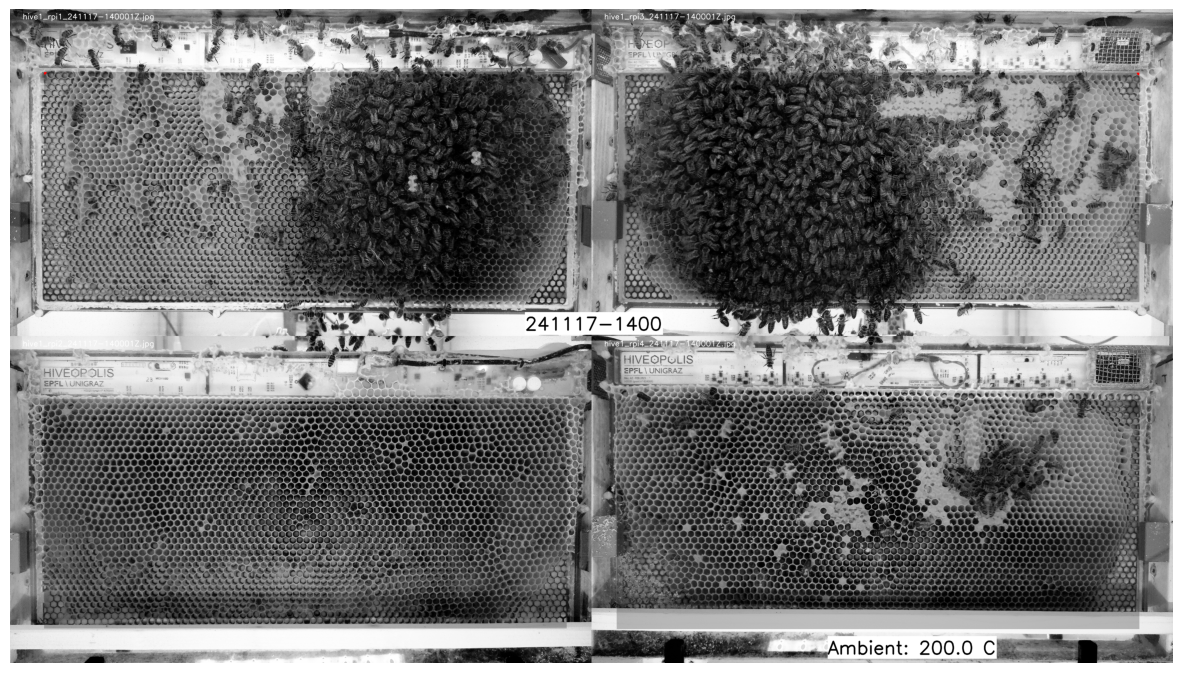

In [5]:
hive = Hive(current_imgs, imgs_names, upper_tf, lower_tf, None, None, None)
snapshot = hive.snapshot()
plt.figure(figsize=(15,10))
plt.imshow(snapshot, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
img_rpi1 = hs_1.pp_imgs[2]
# imshow image
plt.figure(figsize=(10,6))
plt.imshow(img_rpi1, cmap='gray')
plt.show()

# Perform edge detection
edges = cv2.Canny(img_rpi1, 350, 450)
# Plot the edges
plt.figure(figsize=(10, 6))
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection")
plt.axis('off')

# Detect lines using Hough Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=3500, maxLineGap=1200)

# Create a copy of the original image to draw on
output_image = img_rpi1.copy()
if len(output_image.shape) == 2:  # Convert grayscale to BGR for colored drawing
    output_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2BGR)

# Keep only the horizontal lines
if lines is not None:
    lines = [line for line in lines if np.abs(line[0][1] - line[0][3]) < 10]
else:
    raise ValueError("No lines detected")

# Discard lines that are too low on the image
lines = [line for line in lines if line[0][1] < img_rpi1.shape[0] * 0.9]

# Find the line lowest on the image
if lines is not None:
    lowest_line = lines[np.argmax([line[0][1] for line in lines])]
    x1, y1, x2, y2 = lowest_line[0]
    print(x1, y1, x2, y2)
    cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
else:
    raise ValueError("No horizontal lines detected")

# # Draw the lines on the image
# line_lengths = []
# if lines is not None:
#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         line_lengths.append(np.sqrt((x2-x1)**2 + (y2-y1)**2))

# # Draw the longest line
# longest_line = lines[np.argmax(line_lengths)][0]
# x1, y1, x2, y2 = longest_line
# cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)


# Display the resulting image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
plt.title("Detected Straight Lines")
plt.axis('off')
plt.show()

NameError: name 'hs_1' is not defined

In [ ]:
# Same cell as above but for vertical lines
# Perform edge detection
edges = cv2.Canny(img_rpi1, 350, 450)
# Plot the edges
plt.figure(figsize=(10, 6))
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection")
plt.axis('off')

# Detect lines using Hough Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=2000, maxLineGap=600)

# Create a copy of the original image to draw on
output_image = img_rpi1.copy()
if len(output_image.shape) == 2:  # Convert grayscale to BGR for colored drawing
    output_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2BGR)

# Keep only the vertical lines
if lines is not None:
    lines = [line for line in lines if np.abs(line[0][0] - line[0][2]) < 10]

# Discard the lines that are too close to the left border (within 10 pixels)
if lines is not None:
    lines = [line for line in lines if line[0][0] > 10]

# Plot the line that is most to the left
if lines is not None:
    leftmost_line = lines[np.argmin([line[0][0] for line in lines])]
    x1, y1, x2, y2 = leftmost_line[0]
    print(x1, y1, x2, y2)
    cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the resulting image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
plt.title("Detected Straight Lines")
plt.axis('off')
plt.show()